In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to price
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the train_test_split function and set the random_state parameter to 1

In [3]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [4]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [5]:
y_train=np.log1p(df_train.price.values)
y_val=np.log1p(df_val.price.values)
y_test=np.log1p(df_test.price.values)

In [6]:
del df_train['price']
del df_val['price']
del df_test['price']

Now, use DictVectorizer to turn train and validation into matrices:

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [8]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Question 1

Let's train a decision tree regressor to predict the price variable.

* Train a model with max_depth=1

In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
from sklearn.tree import export_text

In [11]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



# ROOM_TYPE

# Question 2
Train a random forest model with these parameters:

* n_estimators=10
* random_state=1
* n_jobs=-1 (optional - to make training faster)

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
rf = RandomForestRegressor(n_estimators=10,
                            n_jobs=-1,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
y_pred = rf.predict(X_val)
y_pred, y_val

(array([4.87505509, 4.79647079, 5.38940092, ..., 5.15387428, 4.76825667,
        5.31395147]),
 array([5.01063529, 3.93182563, 5.01727984, ..., 5.170484  , 4.60517019,
        4.75359019]))

In [15]:
def rmse(y,y_pred):
    se = (y-y_pred)**2
    mse = se.mean()
    return np.sqrt(mse)

In [20]:
score = rmse(y_val, y_pred)
score

0.4615632303514057

# 0.459

# Question 3
Now let's experiment with the n_estimators parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set random_state to 1
* Evaluate the model on the validation dataset

In [21]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, 
                                n_jobs=-1,
                                random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score=rmse(y_val, y_pred)
    
    scores.append((n, score))
    
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

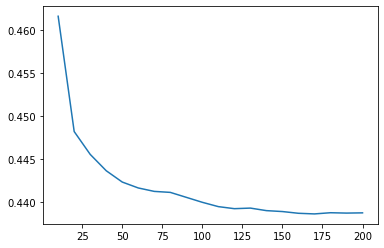

In [22]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

# 120

# Question 4
Let's select the best max_depth:

* Try different values of max_depth: [10, 15, 20, 25]
* For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
* Fix the random seed: random_state=1

In [23]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   n_jobs=-1,
                                   random_state=1)
        rf.fit(X_train, y_train.astype('int'))

        y_pred = rf.predict(X_val)
        score=rmse(y_val.astype('int'), y_pred)
    
        scores.append((d, n, score))

In [24]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

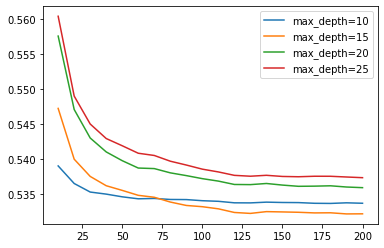

In [25]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

# 15

# Question 5
For this homework question, we'll find the most important feature:

Train the model with these parametes:
* n_estimators=10,
* max_depth=20,
* random_state=1,
* n_jobs=-1 (optional)

Get the feature importance information from this model

In [26]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           n_jobs=-1,
                           random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

In [27]:
importances = (rf.feature_importances_).round(3)
feature_names = dv.get_feature_names()
feature_importances = list(zip(importances, feature_names))
feature_importances

[(0.076, 'availability_365'),
 (0.03, 'calculated_host_listings_count'),
 (0.153, 'latitude'),
 (0.154, 'longitude'),
 (0.053, 'minimum_nights'),
 (0.0, 'neighbourhood_group=Bronx'),
 (0.001, 'neighbourhood_group=Brooklyn'),
 (0.034, 'neighbourhood_group=Manhattan'),
 (0.001, 'neighbourhood_group=Queens'),
 (0.0, 'neighbourhood_group=Staten Island'),
 (0.042, 'number_of_reviews'),
 (0.054, 'reviews_per_month'),
 (0.392, 'room_type=Entire home/apt'),
 (0.004, 'room_type=Private room'),
 (0.005, 'room_type=Shared room')]

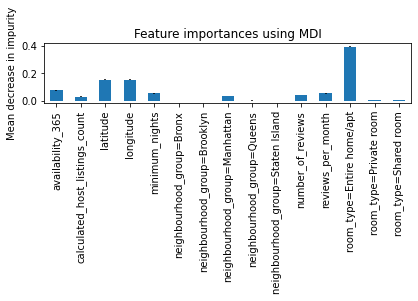

In [29]:
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# room_type=Entire home/apt

# Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

In [30]:
!pip install xgboost

In [31]:
import xgboost as xgb

In [32]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [33]:
scores = {}

In [34]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [43]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [36]:
s = output.stdout
print(s)

[0]	train-rmse:4.25336	val-rmse:4.25010
[5]	train-rmse:4.04779	val-rmse:4.04454
[10]	train-rmse:3.85242	val-rmse:3.84921
[15]	train-rmse:3.66674	val-rmse:3.66359
[20]	train-rmse:3.49030	val-rmse:3.48719
[25]	train-rmse:3.32263	val-rmse:3.31956
[30]	train-rmse:3.16332	val-rmse:3.16029
[35]	train-rmse:3.01196	val-rmse:3.00898
[40]	train-rmse:2.86817	val-rmse:2.86533
[45]	train-rmse:2.73158	val-rmse:2.72884
[50]	train-rmse:2.60185	val-rmse:2.59925
[55]	train-rmse:2.47865	val-rmse:2.47612
[60]	train-rmse:2.36167	val-rmse:2.35927
[65]	train-rmse:2.25061	val-rmse:2.24835
[70]	train-rmse:2.14519	val-rmse:2.14303
[75]	train-rmse:2.04514	val-rmse:2.04311
[80]	train-rmse:1.95022	val-rmse:1.94827
[85]	train-rmse:1.86015	val-rmse:1.85833
[90]	train-rmse:1.77472	val-rmse:1.77302
[95]	train-rmse:1.69373	val-rmse:1.69214
[99]	train-rmse:1.63198	val-rmse:1.63045



In [44]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [45]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

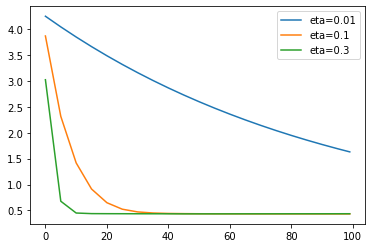

In [46]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.legend()

# 0.3